## Imports

### Imports

In [1]:
# Execute before using this notebook if using google colab
kernel = str(get_ipython())
if 'google.colab' in kernel:    
    !wget https://raw.githubusercontent.com/fredzett/rmqa/master/utils.py -P local_modules -nc 
    !npx degit fredzett/rmqa/data data
    import sys
    sys.path.append('local_modules')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [9,7]
plt.rcParams['figure.dpi'] = 80
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

### Helper functions

In [3]:
from sklearn.model_selection import KFold

In [4]:
def _X_y(data,ycol="mpg"):
    'helper function to create X and y from pandas dataframe'
    y = data[ycol]
    X = data.drop(labels=ycol, axis=1)
    return X, y

In [5]:
def mse(ytrue,yhat):
    'calculate mean squared error'
    return np.sum((ytrue-yhat)**2) / len(ytrue)

In [6]:
def validation(data, size=0.5):
    'Yields train/test split for validation approach'
    X,y = _X_y(data)
    # Create random split
    n = len(data) # total number of observations
    train = np.random.rand(n) < size # randomly choose 

    yield X.iloc[train,:], y[train], X.iloc[~train,:], y[~train]

In [7]:
def loocv(data, *args):
    'Yields train/test split for loocv approach'
    X, y = _X_y(data)
    
    rows = np.arange(len(data))
    for row in rows:
        
        train = rows != row
        
        yield X.iloc[train,:], y[train], X.iloc[~train,:], y[~train]   

In [8]:
def kfold(data, k=5):
    'Yields train/test split for kfold approach'
    X,y = _X_y(data)
     
    kfold = KFold(n_splits=k[0], shuffle=True)
    
    for train, test in kfold.split(df):
       
        yield X.iloc[train,:],y.iloc[train], X.iloc[test,:],  y.iloc[test]

In [9]:
def train_test_split(data, func, *args):
    'Yields train/test split and accepts different approaches as input'
    split_func = func(data, args)
    if len(args) == 0: split_func = func(data)
    for split in split_func:
        yield split

In [10]:
def calc_error(data, split_func, *args):
    'Calculates test error for given cross validation approach'
    errors = []
    counter = 0
    for X_train, y_train, X_test, y_test in train_test_split(data, split_func, *args):
        #print("Run: ", counter + 1)
        model = sm.OLS(y_train, X_train).fit()
        y_hat = model.predict(X_test)
        err = mse(y_test, y_hat)
        errors.append(err)
        counter += 1
    return np.mean(errors)

In [11]:
def _add_polynomial(data, degree, ycols="mpg"):
    
    if degree == 1: return sm.add_constant(df)
    
    X, y = _X_y(data, ycols)
    base = X.copy()
    for i in range(2,degree+1):
        X[f"horsepower_{i}"] = np.power(base, i)
    X = sm.add_constant(X)
    
    return pd.concat((y,X), axis=1)  

In [12]:
def error_per_poly(df, degrees=7, fn=validation, *args):
    errors = []
    
    for i in range(1, degrees+1):
        data = _add_polynomial(df, i)
        err = calc_error(data, fn, *args)
        errors.append(err)
    return errors

In [13]:
def plot_errors(errors, labels=None):
    
    if not isinstance(errors[0], list): errors = [errors]
        
    x = np.arange(1,len(errors[0])+1)    
    for error in errors:
        plt.plot(x,error, marker="o")
    plt.xlabel("Degree of Polynomial")
    plt.ylabel("Mean squared error")
    if labels:
        plt.legend(labels);
    return plt

# Cross validation

Let's illustrate the approach using a familiar data set: the `cars` data set. 

We consider building a model to predict `mpg` (miles per gallon) from `horsepower`.

In [14]:
df = pd.read_csv("./data/Auto.csv", usecols=["mpg", "horsepower"])

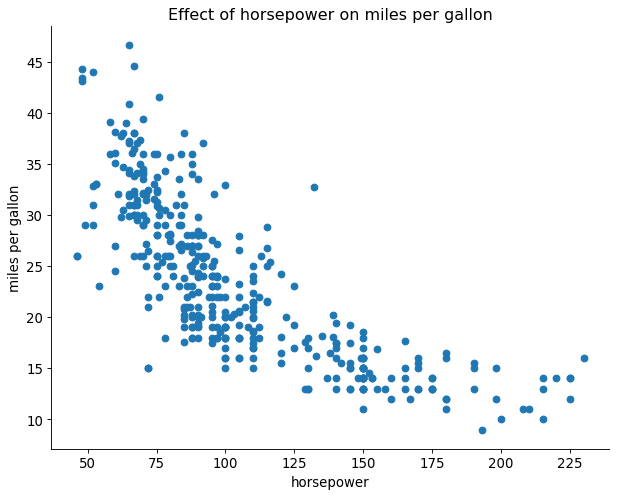

In [15]:
plt.scatter(x="horsepower", y="mpg", data=df)
plt.xlabel("horsepower") 
plt.ylabel("miles per gallon")
plt.title("Effect of horsepower on miles per gallon");

Looking at the data we see that the relationship between `mpg` and `horsepower` is not linear. In Chapter 5 we have learned that we may deal with this non-linearity by transforming one or both variables using logarithms. 

Another strategy is to introduce polynomials into our model, i.e. instead of

$$f(x) = \beta_0 + \beta_1X $$

we could add a term and calculate

$$f(x) = \beta_0 + \beta_1X + \beta_2X^2$$

where $X$ is `horsepower`.

Let's quickly calculate both models and compare how good they are before we proceed:

In [16]:
y, X = dmatrices("mpg ~ horsepower",df,return_type="dataframe")
sm.OLS(y,X).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.605    
Dependent Variable: mpg              AIC:                2361.3237
Date:               2020-12-17 08:39 BIC:                2369.2662
No. Observations:   392              Log-Likelihood:     -1178.7  
Df Model:           1                F-statistic:        599.7    
Df Residuals:       390              Prob (F-statistic): 7.03e-81 
R-squared:          0.606            Scale:              24.066   
-------------------------------------------------------------------
               Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept     39.9359    0.7175   55.6598  0.0000  38.5252  41.3465
horsepower    -0.1578    0.0064  -24.4891  0.0000  -0.1705  -0.1452
------------------------------------------------------------------
Omnibus:               16.432       Durbin-Watson:          0.920 
Prob(Omnibus):         0.000        Jarque-Bera (JB):       17.305
Skew:                  0.492        Prob(JB):               0.000 
Kurtosis:              3.299        Condition No.:          322   
==================================================================

"""

In [17]:
df_2 = _add_polynomial(df, degree=2)

In [18]:
y, X = dmatrices("mpg ~ horsepower + horsepower_2",df_2,return_type="dataframe")
sm.OLS(y,X).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.686    
Dependent Variable: mpg              AIC:                2272.3535
Date:               2020-12-17 08:39 BIC:                2284.2673
No. Observations:   392              Log-Likelihood:     -1133.2  
Df Model:           2                F-statistic:        428.0    
Df Residuals:       389              Prob (F-statistic): 5.40e-99 
R-squared:          0.688            Scale:              19.131   
-------------------------------------------------------------------
               Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept     56.9001    1.8004   31.6037  0.0000  53.3603  60.4399
horsepower    -0.4662    0.0311  -14.9782  0.0000  -0.5274  -0.4050
horsepower_2   0.0012    0.0001   10.0801  0.0000   0.0010   0.0015
------------------------------------------------------------------
Omnibus:               16.158       Durbin-Watson:          1.078 
Prob(Omnibus):         0.000        Jarque-Bera (JB):       30.662
Skew:                  0.218        Prob(JB):               0.000 
Kurtosis:              4.299        Condition No.:          128782
==================================================================
* The condition number is large (1e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

__Considerations__: we can see that the model not only using a linear term but also a squared term is clearly better.

In a predictive modelling setting we have two challenges now:

1. how do we know that the second model is actually _general_ better (i.e. not only due to the specific observations in the data set)?

2. how do we know if adding even higher-order polynomials does increase the model performance (also taking into consideration the first issue)?


We can answer both questions using __cross validation__, i.e. a technique of holding out a subset to “generate“ a test data set from training data set is also called cross validation

Cross validation serves two purposes  
- model assessment, i.e. evaluate model‘s performance
- model selection, i.e. selecting a suited model flexibility


Cross-validation (CV) approaches can be distinguised by way of subsetting the training data set

- Validation set approach
- Leave-One-Out cross-validation
- K-Fold cross-validation



__Example__



Let's consider to run 7 different models for each model increasing the degree of polynomial. So the models are

\begin{equation}
\begin{split}
mpg & = \beta_0 + \beta_1horsepower \\
mpg & = \beta_0 + \beta_1horsepower + \beta_2horsepower^2 \\
mpg & = \ldots \\
mpg & = \beta_0 + \beta_1horsepower + \ldots + \beta_7horsepower^7 \\
\end{split}
\end{equation}

    
We will compare test errors of all seven models for th three CV approaches

# Comparing three cross validation approaches

## Validation approach

We randomly split the data set into two sets both containing half of the data, i.e. given we have a data set with 392 observations

- training data set consists of $\frac{392}{2} = 196$ observations

- validation data set consists of 196 observations

In [31]:
errors_val = error_per_poly(df, 7, validation, 0.5)

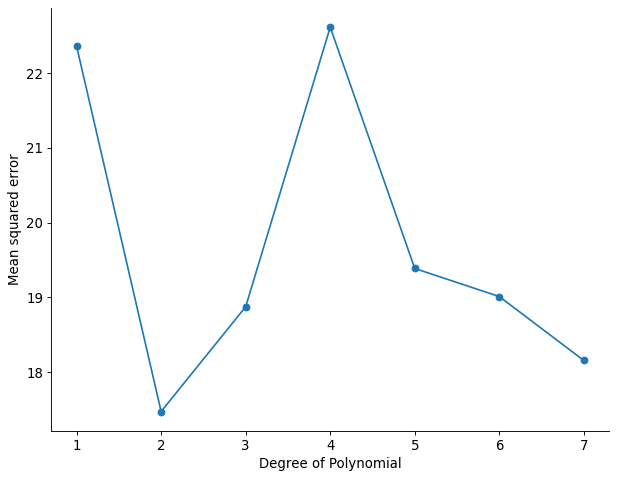

In [32]:
plot_errors(errors_val);

__Problem:__ results are highly dependent on the random splitting. Each time we repeat the split we get a different train/validation split (i.e. different observations in both splits) and results change. 

<module 'matplotlib.pyplot' from '/Users/felix/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

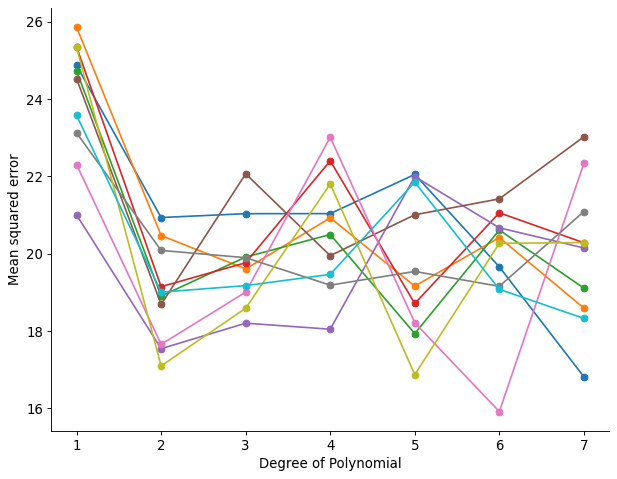

In [33]:
errors_vals = [error_per_poly(df, 7, validation, 0.5) for _ in range(10)]
plot_errors(errors_vals)

## Leave one out cross validation

One disadvantage of the _validation approach_ is that we reduce training size significantly leading to bias in our test error. In addition we see high variance in our test error as it highly depends on the random splitting. 

__Leave one out cross validaiton (LOOCV)__ compensates for these issues by following these steps:

- split data in training set consisting of $n-1$ observations and validation set containing $1$ observation
- fit / calculate model using the training data
- evaluate model by calculating test error on validation set
- repeat this step for all $n$ observations ensuring that each observation is in validation set once
- calculate test error as mean of $n$ test errors

$$CV_{(n)} = \frac{1}{n}\sum_{i=1}^{n} MSE_i$$

In [34]:
errors_loocv = error_per_poly(df, 7, loocv)

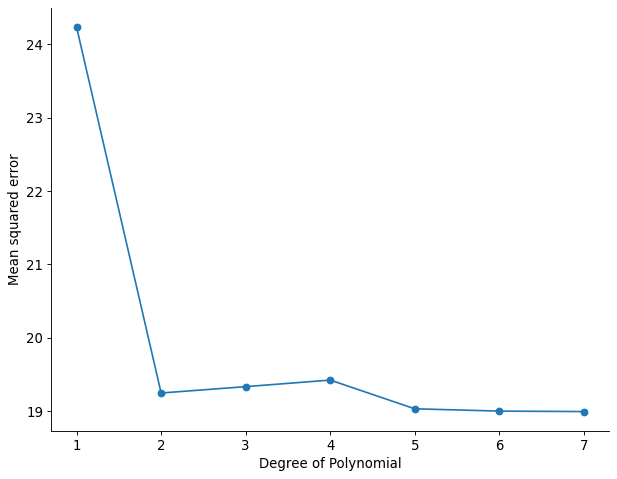

In [35]:
plot_errors(errors_loocv);

The result is not depending on randomness as we used all $n$s for validating. However, the cross validation is compuational expensive for large data sets (as $n$ increases). Even for this small dataset we had to calculate $392*7 = 2744$ models. 

## K-fold cross validation

K-fold cross validation mitigates the computational expensiveness of LOOVC by not using $n$ validation sets but only k. K is usually set to $5$ or $10$

We do the following steps:

- split data into k groups of approximately equal size
- fit / calculate model using the training data consisting of $k - 1$ groups
- evaluate model by calculating test error on validation set consisting of the remaining 1 group
- repeat this step for all $k$ groups ensuring that validation set consists of one group once
- calculate test error as mean of $k$ test errors


$$CV_{(k)} = \frac{1}{k}\sum_{i=1}^{k} MSE_k$$

For $k=5$

In [36]:
errors_kfold = error_per_poly(df, 7 ,kfold, 5)

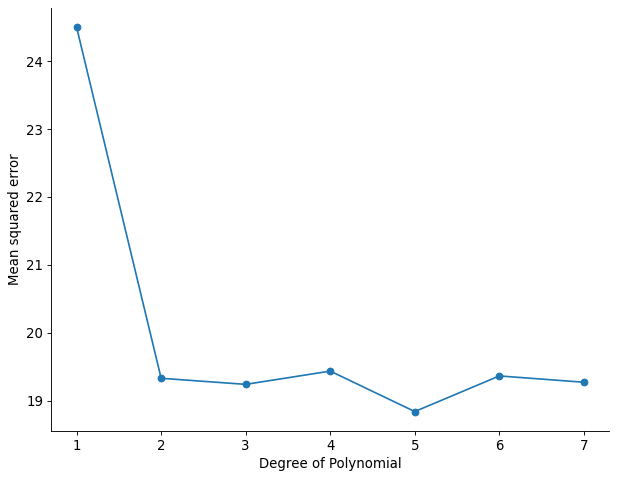

In [37]:
plot_errors(errors_kfold);

## Comparing results for all three approaches

In [38]:

errors = [errors_val, errors_loocv, errors_kfold]

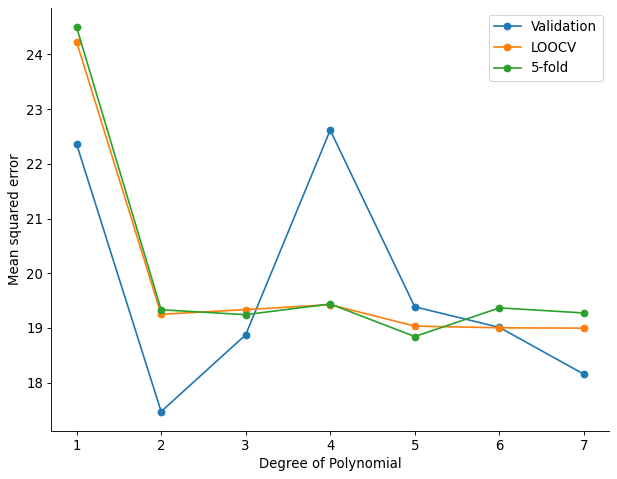

In [40]:
plot_errors(errors, ("Validation", "LOOCV", "5-fold"));